## Bibliotecas

In [ ]:
#!pip install mediapipe

In [1]:
import cv2
import os
import numpy as np
import mediapipe as mp

### Parámetros

In [ ]:
#RUTAS
carpeta_videos = "Videos verdad y mentira procesados"
carpeta_salida_base = "framesObtenidos"
imagenes_por_segundo = 30
# Debido a que los videos fueron grabados a 30 fps, significa que el video contiene 30 imágenes por segundo y por ello extraemos 30 imagenes por segundo,
# pues si se extrajeran menos perdemos información y con ellos la posibilidad de detectar una microexpresión que duro poco.
tamaño_salida = 256 # Obtener resolución de 256x256 px

### Funcion para detectar un rostro en la imagen y recortarla centrada en ese rostro

In [3]:
def recorte_centrado_en_rostro(img, tamaño_salida=256):
    # carga de clasificador haarcascade de opencv para detectar rostros
    detector = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

    # convertimos la imagen a escala de grises si no lo esta
    gris = img if len(img.shape) == 2 else cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # detectar rostros en la imagen con haar
    caras = detector.detectMultiScale(gris, scaleFactor=1.1, minNeighbors=5)

    h, w = img.shape[:2]  # alto y ancho de la imagen

    if len(caras) > 0:
        # si se detecta al menos un rostro se usa el primero
        x, y, ancho, alto = caras[0]
        centro_x = x + ancho // 2
        centro_y = y + alto // 2
        lado_cuadro = int(max(ancho, alto) * 2.0)  # se amplia el cuadro de recorte
    else:
        # si no se detecta rostro se recorta desde el centro de la imagen
        centro_x = w // 2
        centro_y = h // 2
        lado_cuadro = min(w, h)

    # limites del recorte para asegurar que esten dentro de los bordes de la imagen
    izquierda = max(0, centro_x - lado_cuadro // 2)
    arriba = max(0, centro_y - lado_cuadro // 2)
    derecha = min(w, centro_x + lado_cuadro // 2)
    abajo = min(h, centro_y + lado_cuadro // 2)

    # recortar y redimensionar la imagen al tamaño deseado
    recorte = img[arriba:abajo, izquierda:derecha]
    recorte = cv2.resize(recorte, (tamaño_salida, tamaño_salida))
    if len(recorte.shape) == 3:
        recorte = cv2.cvtColor(recorte, cv2.COLOR_BGR2GRAY)
    return recorte

In [4]:
def recorte_centrado(img, tamaño_salida=256):
    h, w = img.shape[:2]  # alto y ancho de la imagen

    # Calcular el tamaño del cuadrado de recorte como el mínimo entre ancho y alto
    lado_cuadro = min(w, h)

    # Coordenadas del centro
    centro_x = w // 2
    centro_y = h // 2

    # Límites del recorte
    izquierda = max(0, centro_x - lado_cuadro // 2)
    arriba = max(0, centro_y - lado_cuadro // 2)
    derecha = izquierda + lado_cuadro
    abajo = arriba + lado_cuadro

    # Recortar y redimensionar
    recorte = img[arriba:abajo, izquierda:derecha]
    recorte = cv2.resize(recorte, (tamaño_salida, tamaño_salida))
    if len(recorte.shape) == 3:
        recorte = cv2.cvtColor(recorte, cv2.COLOR_BGR2GRAY)

    return recorte

## EAR (Eye Aspect Ratio)
Es una medida que se usa en visión por computadora para saber qué tan abiertos o cerrados están los ojos en una imagen

In [5]:
# funcion para calcular el ear
def calcular_ear(ojos):
    # se usan seis puntos por ojo y se calculan tres distancias
    A = np.linalg.norm(ojos[1] - ojos[5])  # distancia vertical uno
    B = np.linalg.norm(ojos[2] - ojos[4])  # distancia vertical dos
    C = np.linalg.norm(ojos[0] - ojos[3])  # distancia horizontal
    # se calcula el ear segun la siguiente formula:
    return (A + B) / (2.0 * C)

### Función para eliminar las imágenes de una carpeta si no detecta un rostro o si los ojos estan cerrados
Se establece el umbral de 0.18 para el EAR porque de acuerdo a las escalas que hay en otros trabajos de visión por computadora se establecen las siguientes:

1. Ojo completamente abierto -> valor de EAR: 0.25 – 0.30
2. Ojo entreabierto -> valor de EAR: 0.20 – 0.24
3. Ojo cerrado o casi cerrado	-> valor de EAR: 0.10 – 0.19

In [6]:
def limpiarFrames(carpeta_frames, umbral_ear=0.18):
    mp_face_mesh = mp.solutions.face_mesh  # cargar el modelo de mediapipe
    eliminados = 0  # contador de imagenes eliminadas

    # usar el modelo para extraer los landmarks
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True) as face_mesh:
        for archivo in os.listdir(carpeta_frames):
            if archivo.lower().endswith('.jpg'):
                ruta = os.path.join(carpeta_frames, archivo)
                imagen = cv2.imread(ruta)  # formato BGR por opencv que carga las imagenes en formato BGR por defecto al momento de usar cv2.imread()
                if imagen is None:
                    continue

                h, w = imagen.shape[:2]
                imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB) # convertir a RGB para mediapipe pq mediapipe usa ese formato
                resultado = face_mesh.process(imagen_rgb)

                if not resultado.multi_face_landmarks:
                    os.remove(ruta)  # eliminar si no se detecta rostro
                    eliminados += 1
                    continue

                puntos = resultado.multi_face_landmarks[0].landmark

                # indices de los puntos de cada ojo segun el modelo de mediapipe
                ojo_izq_idxs = [33, 160, 158, 133, 153, 144]
                ojo_der_idxs = [362, 385, 387, 263, 373, 380]

                # convertir los puntos a coordenadas en pixeles
                ojo_izq = np.array([[puntos[i].x * w, puntos[i].y * h] for i in ojo_izq_idxs])
                ojo_der = np.array([[puntos[i].x * w, puntos[i].y * h] for i in ojo_der_idxs])

                # calcular ear para cada ojo y luego el promedio
                ear_izq = calcular_ear(ojo_izq)
                ear_der = calcular_ear(ojo_der)
                ear_prom = (ear_izq + ear_der) / 2

                # eliminar si el ear esta por debajo del umbral
                if ear_prom < umbral_ear:
                    os.remove(ruta)
                    eliminados += 1

    print(f"    {eliminados} imagenes eliminadas por ear bajo")

### Función para rotar imágenes a la derecha

In [7]:
def rotar_imagenes_derecha(carpeta):
    contador = 0  # contador de imagenes rotadas
    for archivo in os.listdir(carpeta):
        if archivo.lower().endswith('.jpg'):  # ahora solo acepta archivos .jpg
            ruta = os.path.join(carpeta, archivo)
            imagen = cv2.imread(ruta)
            if imagen is not None:
                rotada = cv2.rotate(imagen, cv2.ROTATE_90_CLOCKWISE)
                cv2.imwrite(ruta, rotada)
                contador += 1
    print(f"    {contador} imagenes rotadas a la derecha")

In [8]:
os.makedirs(carpeta_salida_base, exist_ok=True)
for archivo in os.listdir(carpeta_videos):
    if archivo.endswith(".mp4"):
        ruta_video = os.path.join(carpeta_videos, archivo)
        nombre_video = archivo.split(".")[0]
        carpeta_salida = os.path.join(carpeta_salida_base, nombre_video)
        os.makedirs(carpeta_salida, exist_ok=True)

        print(f"\nProcesando video: {archivo}")
        video = cv2.VideoCapture(ruta_video)
        fps = video.get(cv2.CAP_PROP_FPS)
        paso_cuadros = max(1, int(fps / imagenes_por_segundo))

        contador_cuadro = 0
        contador_guardado = 0

        while video.isOpened():
            exito, imagen = video.read()
            if not exito:
                break

            if contador_cuadro % paso_cuadros == 0:
                #recorte = recorte_centrado_en_rostro(imagen, tamaño_salida)
                recorte = recorte_centrado(imagen, tamaño_salida)
                ruta_salida = os.path.join(carpeta_salida, f"frame_{contador_guardado:05d}.jpg")
                cv2.imwrite(ruta_salida, recorte)
                contador_guardado += 1

            contador_cuadro += 1

        video.release()
        print("Limpiando imágenes por EAR...")
        limpiarFrames(carpeta_salida)
        rotar_imagenes_derecha(carpeta_salida)

        # por cada video que se procese, eliminar el video, para ahorrar espacio y no llenarnos
        try:
            os.remove(ruta_video)
            print(f"Video eliminado: {archivo}")
        except Exception as e:
            print(f"No se pudo eliminar {archivo}: {e}")

print("\nProcesamiento listooo :D")


Procesando video: P14_mentira2.mp4
Limpiando imágenes por EAR...
    99 imagenes eliminadas por ear bajo
    173 imagenes rotadas a la derecha
Video eliminado: P14_mentira2.mp4

Procesando video: P100_verdad2.mp4
Limpiando imágenes por EAR...
    86 imagenes eliminadas por ear bajo
    174 imagenes rotadas a la derecha
Video eliminado: P100_verdad2.mp4

Procesando video: P14_verdad1.mp4
Limpiando imágenes por EAR...
    7 imagenes eliminadas por ear bajo
    141 imagenes rotadas a la derecha
Video eliminado: P14_verdad1.mp4

Procesando video: P100_verdad3.mp4
Limpiando imágenes por EAR...
    25 imagenes eliminadas por ear bajo
    131 imagenes rotadas a la derecha
Video eliminado: P100_verdad3.mp4

Procesando video: P100_mentira2.mp4
Limpiando imágenes por EAR...
    36 imagenes eliminadas por ear bajo
    192 imagenes rotadas a la derecha
Video eliminado: P100_mentira2.mp4

Procesando video: P14_verdad3.mp4
Limpiando imágenes por EAR...
    26 imagenes eliminadas por ear bajo
    18

### Tipo de imágenes borradas por bajo EAR
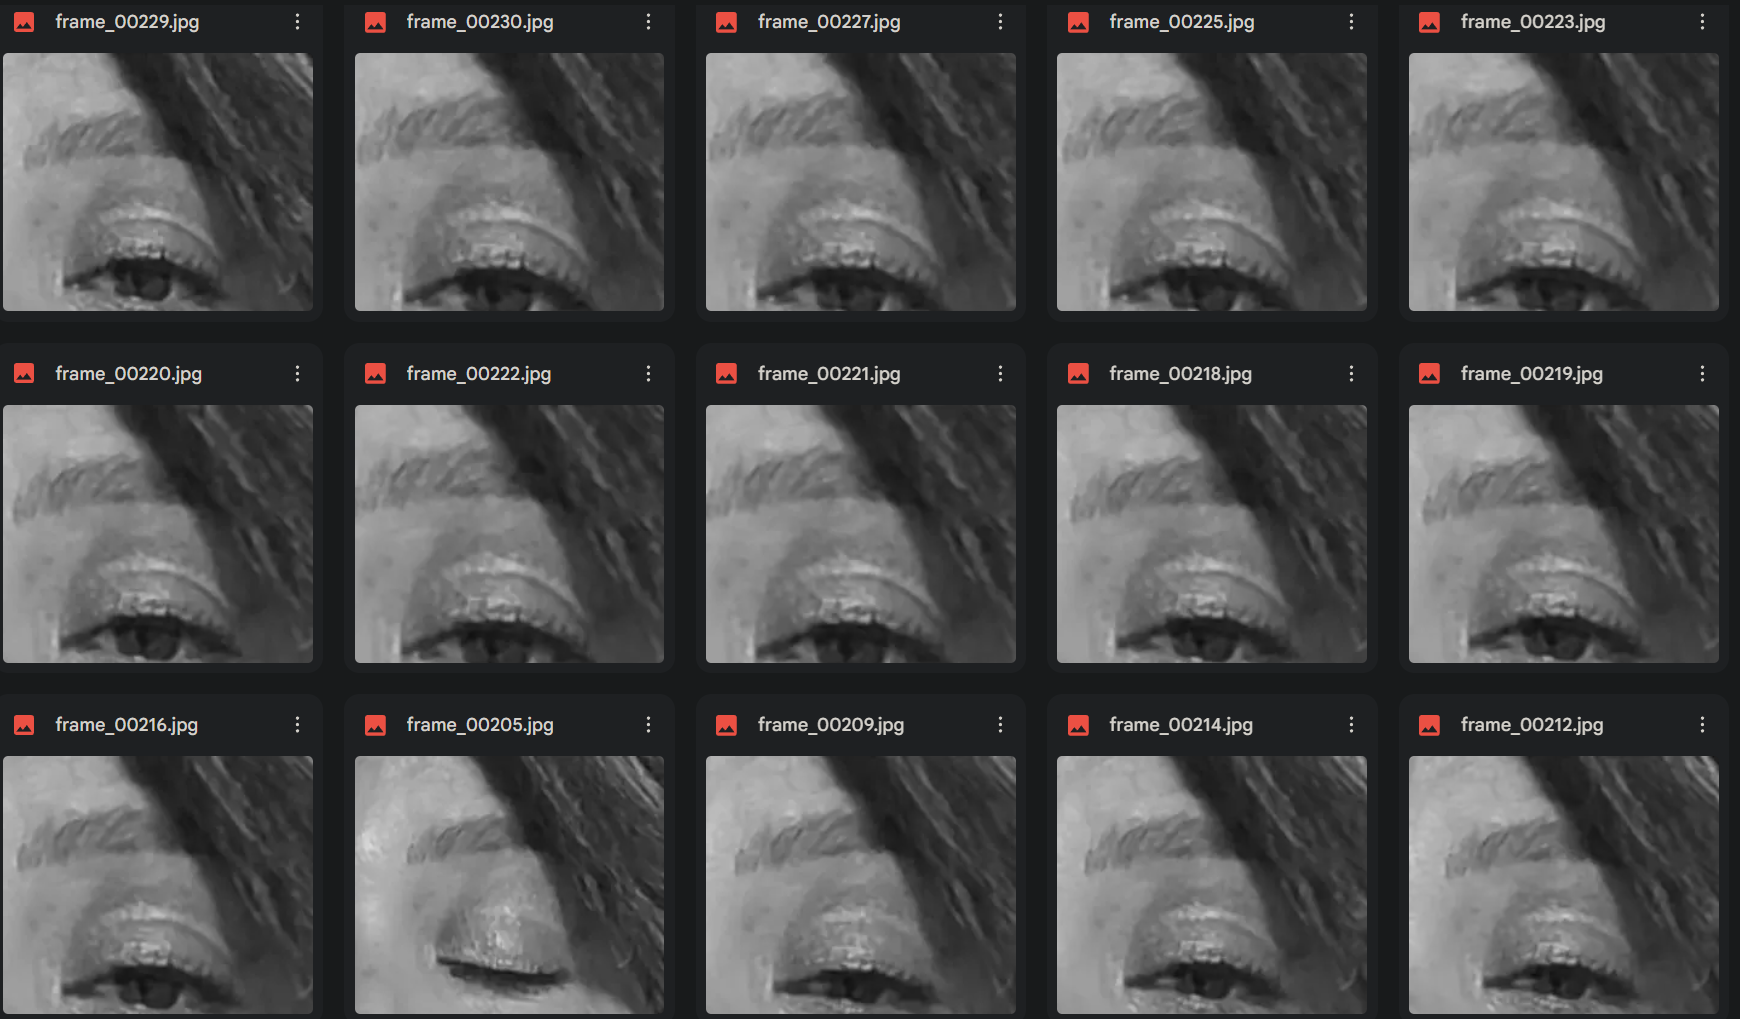

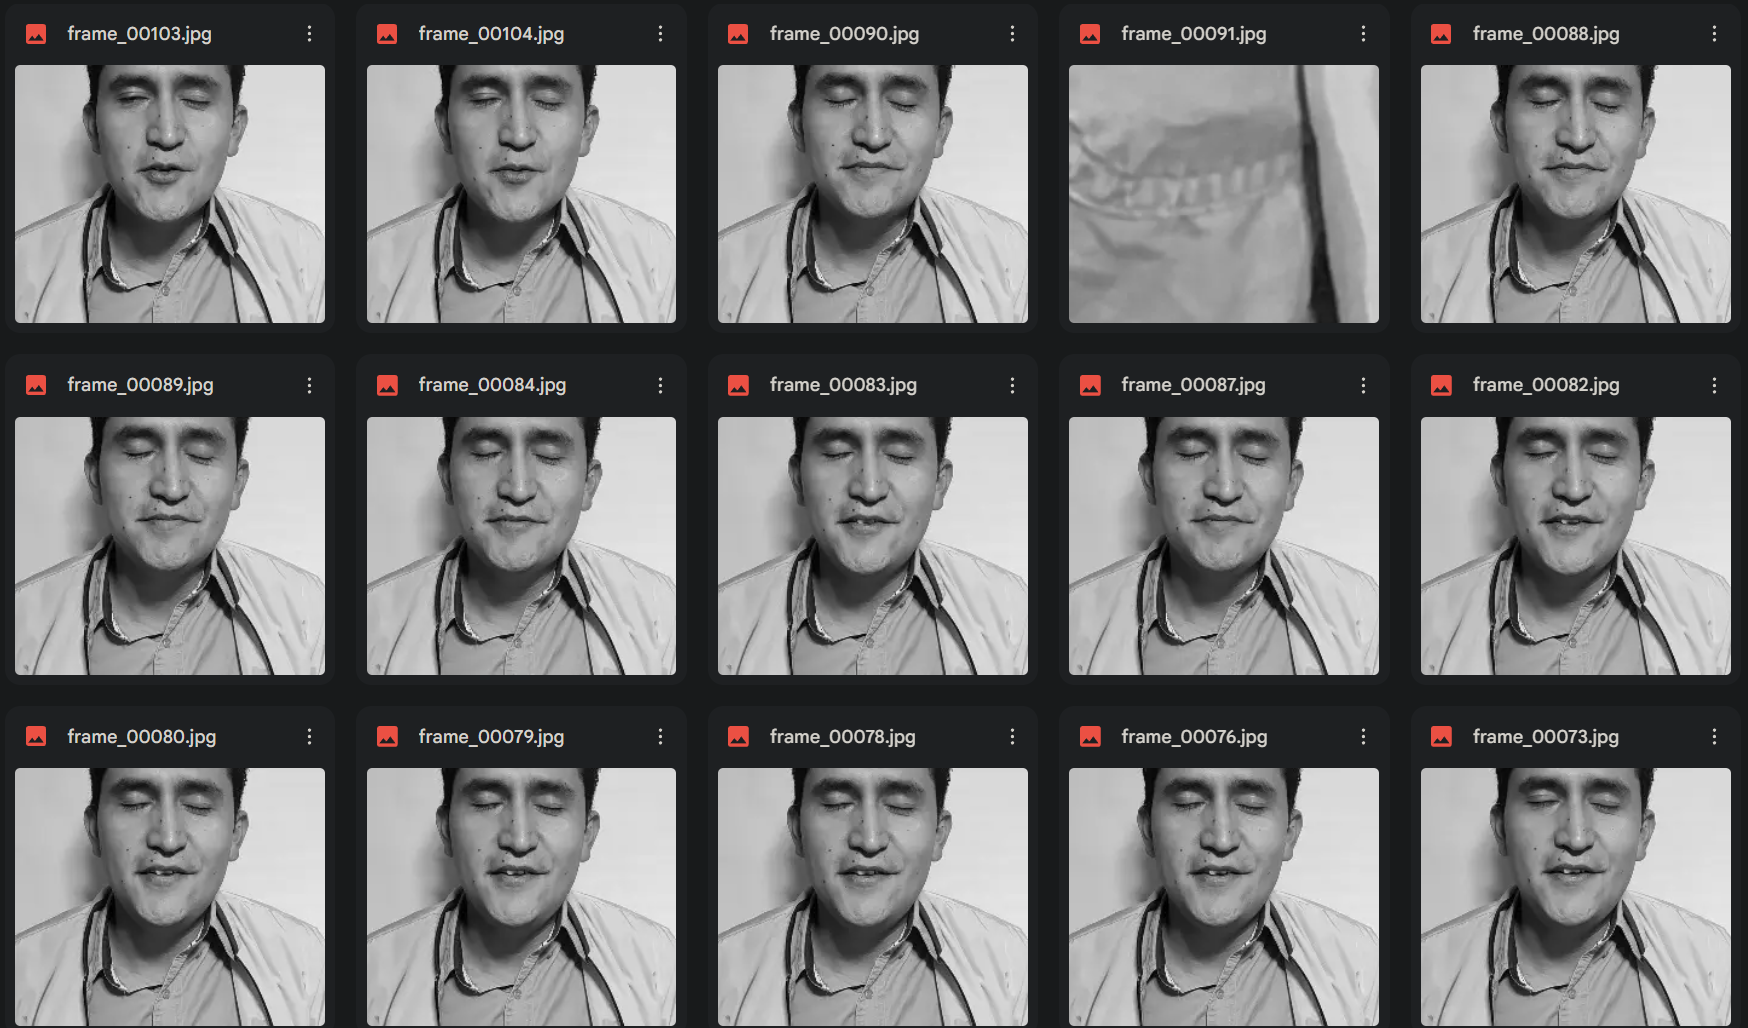